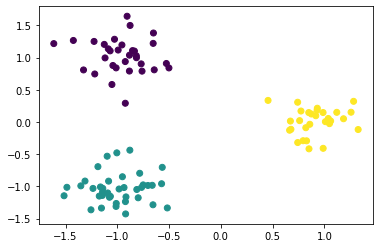

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# To help with testing, we generate synthetic data from 3 Gaussians in 2D
mu = np.array([[-1,1],[-1,-1],[1,0]])
sigma = 0.25
N = 100
y = np.random.randint(3,size=N)
X = np.random.randn(N,2)*sigma + np.array([mu[x] for x in y])
plt.scatter(X[:,0], X[:,1], c=y)

In [2]:
def gini(c, n):
    return 1-sum((p/n)**2 for p in c.values())
def entropy(c, n):
    return -sum((p/n)*np.log((p/n)+1e-7) for p in c.values())
def maxk(c, n):
    return 1-c.most_common()[0][1]/n

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# We put all of the data in first
# if the node is split, we give the data to the children
# then erase the data by setting to None
class Node():
    """Basic Node class.
    
    Parameters: 
        data matrix X of shape (N,D)
        target vector y of shape (N,)
        a parent node called 'parent'
        
    Properties:
        left child of type Node
        right child of type Node
        splitFeature indicating along which feature this node will be split (if the node is not a leaf)
        splitValue indicating value which feature is split. inputs > value go to right child (if node is not a leaf)        )
    """
    id = 0
    def __init__(self, X, y, parent=None, depth=0, impurity=None):
        self.id = Node.id
        Node.id += 1
        self.X = X
        self.y = y
        self.parent = parent
        self.left = None
        self.right = None
        self.depth = depth
        self.splitFeature = None
        self.splitValue = None
        self.impurity = impurity # This is set implicitly upon splitting the root
        self.proba = None
        self.class_prediction = None
        self._setProbas()
        
    def _setProbas(self):
        c = Counter(self.y)
        n = len(self.y)
        self.class_prediction = c.most_common()[0][0]
        for k, v in c.items():
            c[k] = v/n
        self.proba = c

    def __repr__(self):
        return str(self.id)

    def _sortByFeature(self, feature):
        """Performs an in-place sort of the data self.X and targets self.y based on feature.
        Inputs:
            feature - column index on which to sort.
        """
        order = np.argsort(self.X[:,feature])
        self.X = self.X[order] # the [:] ensures we do not copy the array. EDIT it copies no matter what I guess, change it to enforce encapsulation
        self.y = self.y[order] # both are modified in-place

        
    def _splitData(self, feature, partition_index, impurityL, impurityR, cleardata=False):  
        """
        Checks first that the data has already been sorted by feature, then splits. 
        Inputs:
            feature - the column position of the feature to split on
            cleardata - set True if removing data from parent after splitting 
            (only run this option once fully trained)
        Outputs:
            boolean indicating if split was successful (i.e. impurity must decrease)
        """
#         assert((np.argsort(self.X[:,feature]) == np.arange(len(self.X))).all()) # use argsort to avoid float comparisons
        self._sortByFeature(feature)
        k = partition_index
        self.left = Node(self.X[:k+1], self.y[:k+1], self, self.depth+1, impurityL)
        self.right = Node(self.X[k+1:], self.y[k+1:], self, self.depth+1, impurityR)
        self.splitFeature = feature
        self.splitValue = self.X[k, feature]
        if cleardata: 
            self.X = None
            self.y = None
        return True
    
    def _partitionFeature(self, feature):
        """
        Internally sorts the data self.X and self.y according to input feature,
        then computes the optimal split
        Inputs:
            feature - column number of feature to split on.
            func - impurity function (gini, entropy, max, etc.)
        Outputs:
            partition_index - the row on sorted X to split at. The index falls into the lower (by value) region.
            I_delta - weighted change in the impurity after split
        """
        self._sortByFeature(feature)
        c1, c2, n1, n2, n = Counter(), Counter(self.y), 0, len(self.y), len(self.y)
        I_0 = I_best = gini(c2,n2)  
        if self.impurity is None:
            self.impurity = I_0
        I1_best = I2_best = None
        partition_index = None
        for k, label in enumerate(self.y[:-1]):
            n1, n2, c1[label], c2[label] = map(sum,zip((n1,n2,c1[label],c2[label]),(1,-1,1,-1)))
            I1_curr = gini(c1,n1) 
            I2_curr = gini(c2,n2)
            I_curr = (n1/n)*I1_curr + (n2/n)*I2_curr
            if I_curr < I_best:
                I_best = I_curr
                I1_best = I1_curr
                I2_best = I2_curr
                partition_index = k
        min_samples_split = min(partition_index+1, n-partition_index-1) if partition_index else 0
        impurity_decrease = I_0-I_best ## Warning, impurity decrease is a POSITIVE number
        split_cache = feature, partition_index, I1_best, I2_best
        return split_cache, impurity_decrease, min_samples_split

    

In [326]:
class adaboostNode(Node):
    def __init__(self, X, y, w=None, **kwargs):
        super().__init__(X,y,**kwargs)
        self.w = np.ones(len(y))/len(y) if w is None else w
    
    def _gini(self, c, w):
        return 1 - sum((p/w)**2 for p in c.values())
    
    def _sortByFeature(self, feature):
        order = np.argsort(self.X[:,feature])
        self.X = self.X[order] # the [:] ensures we do not copy the array. EDIT it copies no matter what I guess, change it to enforce encapsulation
        self.y = self.y[order] # both are modified in-place
        self.w = self.w[order]
    def _splitData(self, feature, partition_index, impurityL, impurityR):  
        self._sortByFeature(feature)
        k = partition_index
        self.left = adaboostNode(self.X[:k+1], self.y[:k+1], self.w[:k+1], parent=self, depth=self.depth+1, impurity=impurityL)
        self.right = adaboostNode(self.X[k+1:], self.y[k+1:], self.w[k+1:], parent=self, depth=self.depth+1, impurity=impurityR)
        self.splitFeature = feature
        try:
            self.splitValue = (self.w[k+1]*self.X[k+1,feature]+self.w[k]*self.X[k, feature])/(self.w[k+1]+self.w[k])
        except IndexError:
            self.splitValue = self.X[k, feature]
        return True
    def _partitionFeature(self, feature):
        self._sortByFeature(feature)
        w = self.w
        c1, c2, w1 = defaultdict(int), defaultdict(int), 0
        wtot = w2 = np.sum(w)
        for k, z in enumerate(self.y):
            c2[z] += w[k]
        I_0 = I_best = self._gini(c2,w2)  
        if self.impurity is None:
            self.impurity = I_0
        I1_best = I2_best = None
        partition_index = None
        for k, label in enumerate(self.y[:-1]):
            w1, w2, c1[label], c2[label] = map(sum,zip((w1,w2,c1[label],c2[label]),(w[k],-w[k],w[k],-w[k])))
            I1_curr = self._gini(c1,w1) 
            I2_curr = self._gini(c2,w2)
            I_curr = (w1/wtot)*I1_curr + (w2/wtot)*I2_curr
            if I_curr < I_best:
                I_best = I_curr
                I1_best = I1_curr
                I2_best = I2_curr
                partition_index = k
        min_samples_split = min(partition_index+1, len(y)-partition_index-1) if partition_index else 0
        impurity_decrease = I_0-I_best ## Warning, impurity decrease is a POSITIVE number
        split_cache = feature, partition_index, I1_best, I2_best
        return split_cache, impurity_decrease, min_samples_split
    
a = adaboostNode(X, y, y)

In [327]:
class adaboostDecisionTree(DecisionTree):
    def fit(self, X, y, w):
        adaboostNode.id = 0
        self.root = adaboostNode(X, y, w)
        leaves = self._growTree(self.root)
        leaves = self._pruneTree(leaves)
        self.num_leaves = len(leaves)
        self.depth = max(leaf.depth for leaf in leaves)
        self._clearData()
        
    def _updateWeights(self, X, y, w):
        y_pred = np.apply_along_axis(self.predict, 1, X)
        eps = np.sum(w[y_pred != y])/np.sum(w)
        alpha = 0.5*np.log((1-eps)/(eps+1e-7))
        w *= np.exp(-alpha*(y_pred==y))
        w = w/np.sum(w)
        return alpha, w
            
    def _pruneTree(self, leaves):
        max_depth = self.max_depth
        lam = self.lam
        curr_depth = max(leaf.depth for leaf in leaves)
        curr_leaf_nodes = len(leaves)
        while len(leaves) > 1:
            best_impurity_increase = float('inf')
            parent_leaf = None
            for leaf in leaves:
                I_parent = leaf.parent.impurity
                I_left = (np.sum(leaf.parent.left.w)/np.sum(leaf.parent.w))*leaf.parent.left.impurity
                I_right = (np.sum(leaf.parent.right.w)/np.sum(leaf.parent.w))*leaf.parent.right.impurity
                curr_impurity_increase = I_parent - I_left - I_right
                is_a_pair = (leaf.parent.left in leaves) and (leaf.parent.right in leaves)
                if is_a_pair and curr_impurity_increase < best_impurity_increase:
                    best_impurity_increase = curr_impurity_increase
                    parent_leaf = leaf.parent
            if best_impurity_increase < 2*lam or curr_depth > max_depth:
                leaves.remove(parent_leaf.left)
                leaves.remove(parent_leaf.right)
                leaves.add(parent_leaf)
                parent_leaf.left = parent_leaf.right = None # remove these from memory
            else:
#                 if curr_depth <= max_depth:
#                     print("Reached max tree depth: ", self.max_depth)
#                 elif best_impurity_increase >= 2*lam:
#                     print("Decreasing gains from complexity reduction.")
                print(f"Pruned tree contains {len(leaves)} leaves.")
                return leaves
            curr_depth = max(leaf.depth for leaf in leaves)
            curr_leaf_nodes = len(leaves)
#         print("Pruned all leaves, only root node remains.\nWe suggest lowering lambda and increasing max_leaf_nodes")
        return leaves

In [348]:
import time
class AdaBoost():
    def __init__(self,
                 boost_iterations = 10,
                 lam=0.1,
                 max_depth=20,
                 min_samples_split=5,
                 max_leaf_nodes=100,
                 random_seed=42,
                 min_impurity_decrease=0,
                 select_random_feature=False,
                 features=None
                ):
        
        self.root = None
        self.alphas = []
        self.decisiontrees = []
        self.boost_iterations = boost_iterations
        self.lam = lam
        self.features = features
        self.select_random_feature = select_random_feature
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leaf_nodes = max_leaf_nodes
        self.random_seed = random_seed
        self.min_impurity_decrease = min_impurity_decrease
        self.num_leaves = None
        self.depth = None
        self.params = {'lam':lam,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'max_leaf_nodes':max_leaf_nodes,
                       'random_seed':random_seed,
                       'min_impurity_decrease':min_impurity_decrease,
                       'select_random_feature':select_random_feature,
                       'features':features}
    
    def fit(self, X, y):
        w = np.ones(len(y))/len(y)
        for i in range(self.boost_iterations):
            toc = time.time()
            dt = adaboostDecisionTree(**self.params)
            dt.fit(X, y, w)
            a, w = dt._updateWeights(X, y, w)
            self.alphas.append(a)
            self.decisiontrees.append(dt)
            y_pred = np.apply_along_axis(self.predict, 1, X)
            tic = time.time()
            print(f"Iteration {i}/{self.boost_iterations}.\talpha: {a:.3f}\tAccuracy: {np.mean(y_pred==y):.3f}\t{tic-toc:.3f} sec./iter")
            if a < 0.01:
                print("alpha sufficiently small. Ending training.")
                return
            
    def predict(self, x):
        c = defaultdict(int)
        for i in range(len(self.decisiontrees)):
            c[self.decisiontrees[i].predict(x)] += self.alphas[i]
        return max(c.keys(), key=lambda z: c[z])
            

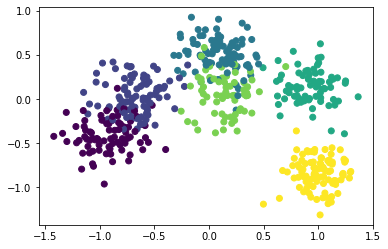

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# To help with testing, we generate synthetic data from K Gaussians in 2D
mu = np.array([[-1,1],[-1,-1],[1,0]])
K = 6
mu = np.random.rand(K,2)*2-1
sigma = 0.2
N = 500
y = np.random.randint(K,size=N)
X = np.random.randn(N,2)*sigma + np.array([mu[x] for x in y])
plt.scatter(X[:,0], X[:,1], c=y)

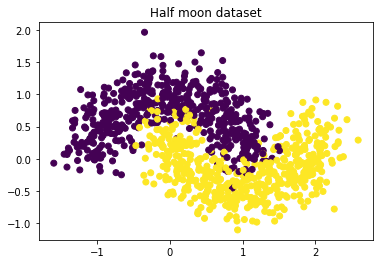

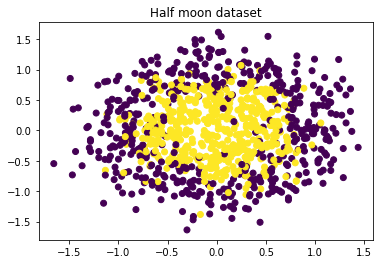

In [378]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, shuffle=True, noise=.25, random_state=None)
plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Half moon dataset')
plt.show()

from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, shuffle=True, noise=.25, random_state=None, factor=0.5)
plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Half moon dataset')
plt.show()

In [381]:
adt = AdaBoost(lam=0.05, boost_iterations=20, select_random_feature=True)
adt.fit(X, y)

Pruned tree contains 76 leaves.
Iteration 0/20.	alpha: 1.188	Accuracy: 0.915	0.973 sec./iter
Pruned tree contains 70 leaves.
Iteration 1/20.	alpha: 0.899	Accuracy: 0.915	0.954 sec./iter
Pruned tree contains 76 leaves.
Iteration 2/20.	alpha: 0.809	Accuracy: 0.938	0.913 sec./iter
Pruned tree contains 87 leaves.
Iteration 3/20.	alpha: 0.627	Accuracy: 0.935	0.891 sec./iter
Pruned tree contains 82 leaves.
Iteration 4/20.	alpha: 0.503	Accuracy: 0.948	0.927 sec./iter
Pruned tree contains 92 leaves.
Iteration 5/20.	alpha: 0.806	Accuracy: 0.953	0.872 sec./iter
Pruned tree contains 53 leaves.
Iteration 6/20.	alpha: 0.284	Accuracy: 0.959	0.715 sec./iter
Pruned tree contains 74 leaves.
Iteration 7/20.	alpha: 0.372	Accuracy: 0.959	0.797 sec./iter
Pruned tree contains 89 leaves.
Iteration 8/20.	alpha: 0.212	Accuracy: 0.960	0.932 sec./iter
Pruned tree contains 81 leaves.
Iteration 9/20.	alpha: 0.349	Accuracy: 0.965	0.947 sec./iter
Pruned tree contains 82 leaves.
Iteration 10/20.	alpha: 0.554	Accuracy

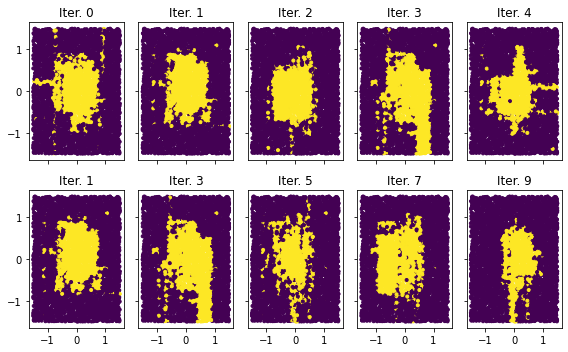

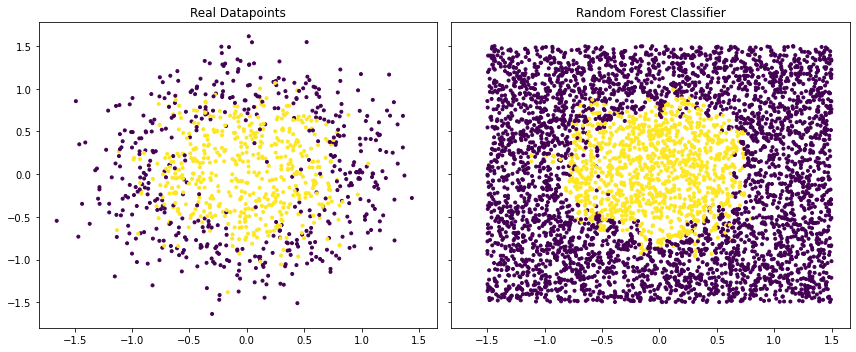

In [382]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(8,5))

Xnew = np.random.rand(5000,2)*3-1.5
for i in range(2):
    for j in range(5):
        dt = adt.decisiontrees[i+j*(i+1)]
        c = np.apply_along_axis(dt.predict, 1, Xnew)
        axs[i,j].scatter(Xnew[:,0], Xnew[:,1], c=c, marker='.')
        axs[i,j].set_title(f"Iter. {i+j*(i+1)}")        

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,5))

axs[0].scatter(X[:,0], X[:,1], c=y, marker='.')
axs[0].set_title("Real Datapoints")
c = np.apply_along_axis(adt.predict, 1, Xnew)
axs[1].scatter(Xnew[:,0], Xnew[:,1], c=c, marker='.')
axs[1].set_title("Random Forest Classifier")
plt.tight_layout()
plt.show()

In [137]:
h = Node(X, y)
split_cache, impurity_decrease, min_samples = h._partitionFeature(0)
print(split_cache)
h._splitData(*split_cache)
h.left.impurity

(0, 665, 0.5712018324630938, 0.2657678654666714)


0.5712018324630938

In [325]:
class DecisionTree():
    def __init__(self, 
                 lam=0.1,
                 max_depth=20,
                 min_samples_split=5,
                 max_leaf_nodes=100,
                 random_seed=42,
                 min_impurity_decrease=0,
                 select_random_feature=False,
                 features=None
                ):
        
        self.root = None
        self.lam = lam
        self.features = features
        self.select_random_feature = select_random_feature
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leaf_nodes = max_leaf_nodes
        self.random_seed = random_seed
        self.min_impurity_decrease = min_impurity_decrease
        self.num_leaves = None
        self.depth = None
        
    def fit(self, X, y):
        Node.id = 0
        self.root = Node(X,y)
        leaves = self._growTree(self.root)
        leaves = self._pruneTree(leaves)
        self.num_leaves = len(leaves)
        self.depth = max(leaf.depth for leaf in leaves)
        self._clearData()
#         print(leaves)
        
    def predict(self, x):
        node = self._findLeaf(x)
        return node.class_prediction
    
    def proba(self, x):
        node = self._findLeaf(x)
        return node.proba
    
    def _findLeaf(self, x):
        root = self.root
        while root.left or root.right:
            feature = root.splitFeature
            value = root.splitValue
            root = root.left if x[feature] <= value else root.right
        return root
    
                    
    def _growTree(self, root, features=None, select_random_feature=False):
        features = range(self.root.X.shape[1]) if self.features is None else self.features
        max_leaf_nodes = self.max_leaf_nodes
        min_sample_split = self.min_samples_split
        leaves = set([root])
        for _ in range(max_leaf_nodes):
            best_leaf = None
            best_impurity_decrease = self.min_impurity_decrease
            best_split_cache = None
            feature_list = [np.random.choice(features)] if self.select_random_feature else features

            for leaf in leaves:
                for feature in feature_list:
                    curr_split_cache, curr_impurity_decrease, sample_split = leaf._partitionFeature(feature)
                    if curr_impurity_decrease > best_impurity_decrease and sample_split >= min_sample_split:
                        best_impurity_decrease = curr_impurity_decrease
                        best_split_cache = curr_split_cache
                        best_leaf = leaf

            if best_leaf is None:
#                 print("Cannot find a split. Terminating unpruned tree with ", len(leaves), " leaves.")
                return leaves
            else:
                leaves.remove(best_leaf)
                best_leaf._splitData(*best_split_cache)
                leaves.add(best_leaf.left)
                leaves.add(best_leaf.right)
#         print(f"Grew tree to maximum size: {max_leaf_nodes} leaf nodes")
        return leaves
                    
    # prune the tree. Prune max n times. Each time, scan all leaves. 
    # Combine two leaves if 2*lambda > increase_in_impurity
    # this is the same as a loss function Q+lambda*T for T the number of leaves, Q the total impurity
    def _pruneTree(self, leaves):
        max_depth = self.max_depth
        lam = self.lam
        curr_depth = max(leaf.depth for leaf in leaves)
        curr_leaf_nodes = len(leaves)

        while len(leaves) > 1:
            best_impurity_increase = float('inf')
            parent_leaf = None

            # NOTE: this definition is different than that used for growing the tree.
            for leaf in leaves:
                I_parent = leaf.parent.impurity
                I_left = (len(leaf.parent.left.y)/len(leaf.parent.y))*leaf.parent.left.impurity
                I_right = (len(leaf.parent.right.y)/len(leaf.parent.y))*leaf.parent.right.impurity
                curr_impurity_increase = I_parent - I_left - I_right
                is_a_pair = (leaf.parent.left in leaves) and (leaf.parent.right in leaves)
                if is_a_pair and curr_impurity_increase < best_impurity_increase:
                    best_impurity_increase = curr_impurity_increase
                    parent_leaf = leaf.parent

            if best_impurity_increase < 2*lam or curr_depth > max_depth:
                leaves.remove(parent_leaf.left)
                leaves.remove(parent_leaf.right)
                leaves.add(parent_leaf)
                parent_leaf.left = parent_leaf.right = None # remove these from memory
            else:
#                 if curr_depth <= max_depth:
#                     print("Reached max tree depth: ", self.max_depth)
#                 elif best_impurity_increase >= 2*lam:
#                     print("Decreasing gains from complexity reduction.")
#                 print(f"Pruned tree contains {len(leaves)} leaves.")
                return leaves

            curr_depth = max(leaf.depth for leaf in leaves)
            curr_leaf_nodes = len(leaves)
#         print("Pruned all leaves, only root node remains.\nWe suggest lowering lambda and increasing max_leaf_nodes")
        return leaves
    
    def _clearDataAux(self, node):
        if node:
            self._clearDataAux(node.left)
            node.y = node.X = None
            self._clearDataAux(node.right)
        
    def _clearData(self):
        self._clearDataAux(self.root)
            
    def printTree(self):
        from graphviz import Digraph
        def aux(g, root):
            if root:
                aux(g, root.left)
                label = None
                if root.parent:
                    sgn = "<" if root.parent.left == root else ">"
                    label = f"x_{root.parent.splitFeature} {sgn} {root.parent.splitValue:.2f}"
                g.edge(str(root.parent), f"{root}", label=label)
                aux(g, root.right)
        g = Digraph()
        root = self.root
        aux(g, root)
        return g

In [305]:
import time
class RandomForest():
    def __init__(self,
                 lam=0.1,
                 forest_depth=100,
                 max_depth=20,
                 min_samples_split=5,
                 max_leaf_nodes=100,
                 random_seed=42,
                 min_impurity_decrease=0,
                 sample_fraction=1,
                 select_random_feature=False):
        
        self.forest = []
        self.forest_depth = forest_depth
        self.lam = lam
        self.select_random_feature = select_random_feature
        self.sample_fraction = sample_fraction
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leaf_nodes = max_leaf_nodes
        self.random_seed = random_seed
        self.min_impurity_decrease = min_impurity_decrease
        
    def _fitDecisionTree(self, X, y):
        train_size, feature_dim = X.shape
        reduced_feature_dim = max(2,int(np.sqrt(feature_dim)+0.5)) # Avoid having only 1 feature in D=2
        features = np.random.choice(np.arange(feature_dim), reduced_feature_dim, replace=False)
        train_subset = np.random.choice(np.arange(train_size), int(train_size*self.sample_fraction))
        Xnew = X[train_subset]
        ynew = y[train_subset]
        dt = DecisionTree(
            select_random_feature=self.select_random_feature,
            features=features,
            lam = self.lam,
            max_depth = self.max_depth,
            min_impurity_decrease=self.min_impurity_decrease,
            max_leaf_nodes=self.max_leaf_nodes,
            random_seed=self.random_seed)        
        dt.fit(Xnew, ynew)
        return dt
    
    def fit(self, X, y):
        print("*"+"~"*20+" Training Decision Trees " + "~"*20 + "*")
        for i in range(self.forest_depth):
            a = int(((i+1)/self.forest_depth)*30)
            b = 30-a
            tic = time.time()
            self.forest.append(self._fitDecisionTree(X, y))
            print(f"Iteration {i}/{self.forest_depth}:\t","["+ "="*a + ">" + "."*b + "]", f"\t{time.time()-tic:.3e} iter/sec.",end="\r")
    
    def predict(self, x):
        """We predict by choosing class with highest average probability, not direct voting."""
        probas = defaultdict(int)
        for dt in self.forest:
            c = dt.proba(x)
            vote, p = c.most_common()[0]
            probas[vote] += p
        return max(probas.keys(), key=lambda z: probas[z])
        

In [306]:
rf = RandomForest(select_random_feature=True)

In [307]:
rf.fit(X, y)

*~~~~~~~~~~~~~~~~~~~~ Training Decision Trees ~~~~~~~~~~~~~~~~~~~~*


In [312]:
rf.predict(X[10])

1

Text(0, 0.5, 'x_1')

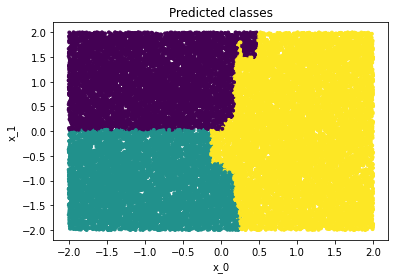

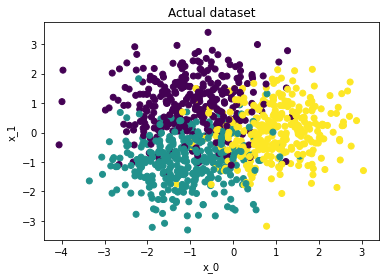

In [314]:
Xnew = np.random.rand(25000,2)*4-2
c = np.apply_along_axis(rf.predict, 1, Xnew)
plt.scatter(Xnew[:,0], Xnew[:,1], c=c, marker='.')
plt.title("Predicted classes")
plt.xlabel("x_0")
plt.ylabel("x_1")

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y)
plt.title("Actual dataset")
plt.xlabel("x_0")
plt.ylabel("x_1")

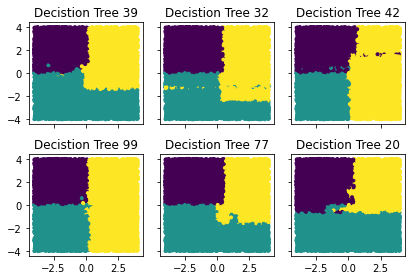

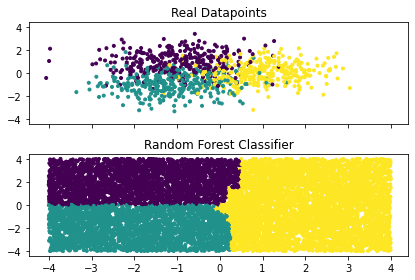

In [332]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

Xnew = np.random.rand(10000,2)*8-4
for i in range(2):
    for j in range(3):
        k = np.random.choice(np.arange(rf.forest_depth))
        dt = rf.forest[k]
        c = np.apply_along_axis(dt.predict, 1, Xnew)
        axs[i,j].scatter(Xnew[:,0], Xnew[:,1], c=c, marker='.')
        axs[i,j].set_title(f"Decistion Tree {k}")        

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(2, sharex=True, sharey=True)

axs[0].scatter(X[:,0], X[:,1], c=y, marker='.')
axs[0].set_title("Real Datapoints")
c = np.apply_along_axis(rf.predict, 1, Xnew)
axs[1].scatter(Xnew[:,0], Xnew[:,1], c=c, marker='.')
axs[1].set_title("Random Forest Classifier")
plt.tight_layout()
plt.show()